# Supervised Learning: Polynomial Regression (Project)

<h2>Table of Contents</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href='https://#Loading'>Loading the Churn Boston Housing Data</a></li>
        <li><a href="https://#EDA">Exploratory Data Analysis (EDA)</a></li>
        <li><a href="https://#FE">Feature Engineering: Target Variable and Normality Tests</a></li>
        <li><a href="https://#Regression">Regression Analysis</a></li>
</div>
<br>
<hr>


In [8]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import normaltest
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from tabulate import tabulate

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, PolynomialFeatures)

In [9]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

<a id ="1"></a>
# 1. Loading the Churn Boston Housing Data

In [11]:
with open('data/boston_housing_clean.pickle', 'rb') as to_read:
    boston = pd.read_pickle(to_read)
boston_data = boston['dataframe']
boston_description = boston['description']

In [12]:
boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


<h2 id = 'EDA'>2. Exploratory Data Analysis (EDA) </h2> 

In [13]:
boston_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [14]:
# Descriptive statistics
descr_stats = boston_data.describe()
descr_stats.loc['range'] = descr_stats.loc['max'] - descr_stats.loc['min']
descr_stats.style.format(precision=3).background_gradient(cmap='GnBu_r')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000
mean,3.594,11.364,11.137,0.069,0.555,6.285,68.575,3.795,9.549,408.237,18.456,356.674,12.653,22.533
std,8.597,23.322,6.860,0.254,0.116,0.703,28.149,2.106,8.707,168.537,2.165,91.295,7.141,9.197
min,0.006,0.000,0.460,0.000,0.385,3.561,2.900,1.130,1.000,187.000,12.600,0.320,1.730,5.000
25%,0.082,0.000,5.190,0.000,0.449,5.885,45.025,2.100,4.000,279.000,17.400,375.377,6.950,17.025
50%,0.257,0.000,9.690,0.000,0.538,6.208,77.500,3.207,5.000,330.000,19.050,391.440,11.360,21.200
75%,3.647,12.500,18.100,0.000,0.624,6.623,94.075,5.188,24.000,666.000,20.200,396.225,16.955,25.000
max,88.976,100.000,27.740,1.000,0.871,8.780,100.000,12.127,24.000,711.000,22.000,396.900,37.970,50.000
range,88.970,100.000,27.280,1.000,0.486,5.219,97.100,10.997,23.000,524.000,9.400,396.580,36.240,45.000


Text(0.5, 1.0, 'Boston Housing Data: Correlation Heatmap')

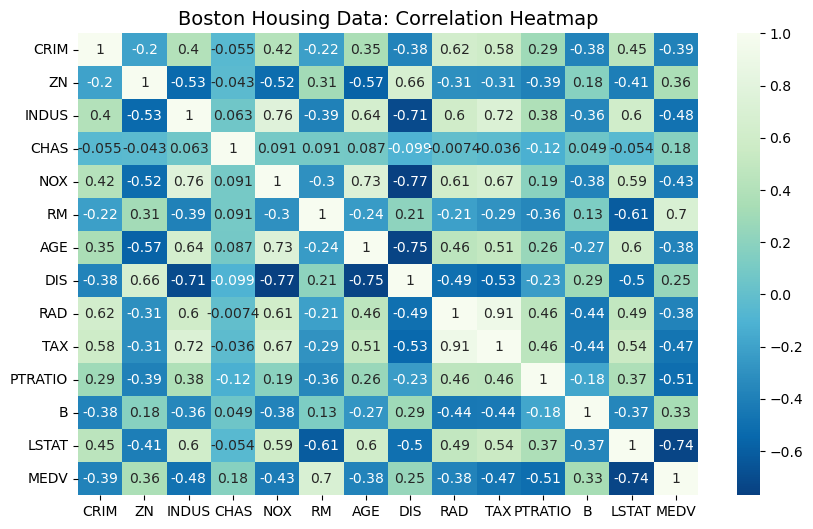

In [15]:
# Correlation analysis
plt.subplots(figsize=(10, 6))
sns.heatmap(boston_data.corr(), annot = True, cmap = 'GnBu_r')
plt.title('Boston Housing Data: Correlation Heatmap', fontsize = 14)

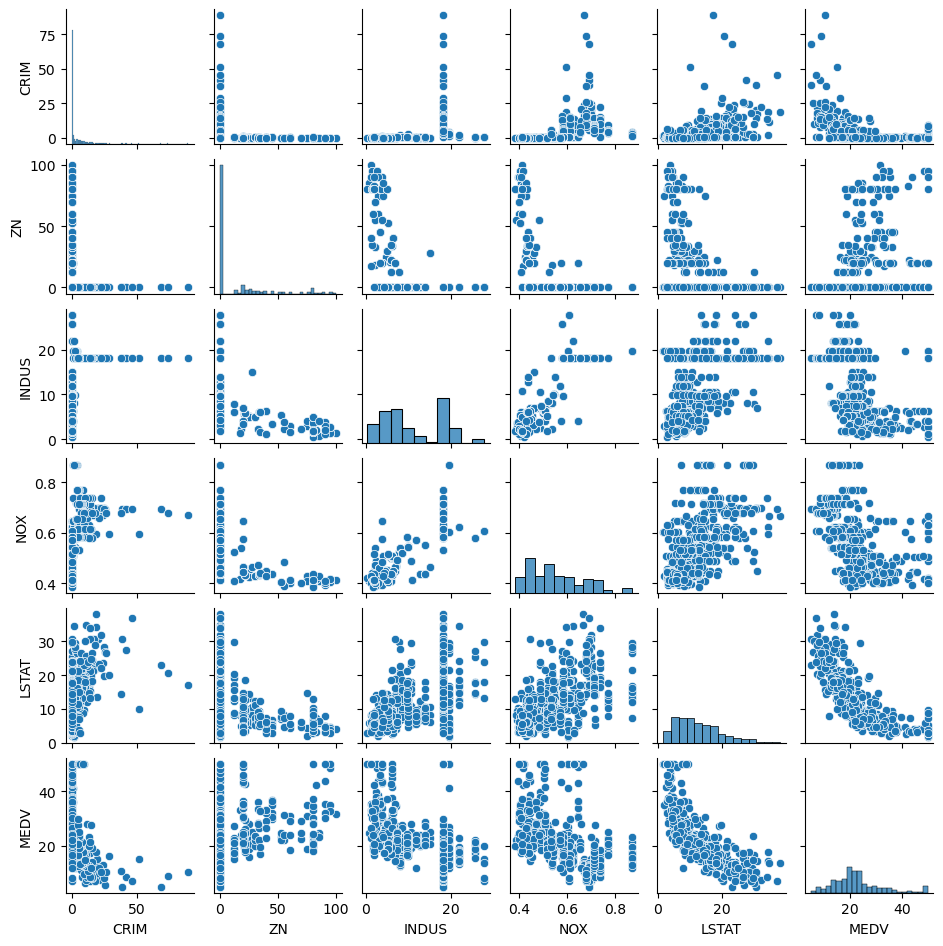

In [16]:
# Selected data pairplot
sel_cols = ['CRIM', 'ZN', 'INDUS', 'NOX', 'LSTAT', 'MEDV']
sns.pairplot(boston_data[sel_cols], height = 1.6);

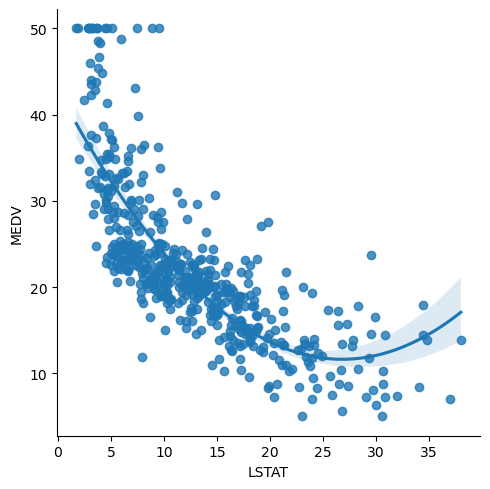

In [51]:
# Visualize the relationship between the 'CRIM' and the target variable 'MEDV'
sns.lmplot(x = 'LSTAT', y = 'MEDV', data = boston_data, order=2, height = 5);

<h2 id = 'FE'>3.Feature Engineering: Target Variable and Normality Tests </h2>

In [20]:
# Original data: Normality test
k_2 = normaltest(boston_data.MEDV.values)
print(f'Original Data: Chi^2 = {k_2[0]:.3f}, P-value: {k_2[1]:.20f}')
print('Extremely low p-value clarifies the absence of target variable\'s normality.')

Original Data: Chi^2 = 90.975, P-value: 0.00000000000000000002
Extremely low p-value clarifies the absence of target variable's normality.


In [21]:
# 1. Log transformation
log_medv = np.log(boston_data.MEDV)
norm_log = normaltest(log_medv)
print(f'Log Transformation: Chi^2 = {norm_log[0]:.3f}, P-value = {norm_log[1]:.5f}')

Log Transformation: Chi^2 = 17.218, P-value = 0.00018


In [22]:
# 2. Square Root Transformation
sqrt_medv = np.sqrt(boston_data.MEDV)
norm_sqrt = normaltest(sqrt_medv)
print(f'Square-Root Transfromation: Chi^2 = {norm_sqrt[0]:.3f}, P-value = {norm_sqrt[1]:.5f}')

Square-Root Transfromation: Chi^2 = 20.487, P-value = 0.00004


In [24]:
# 3. Boxcox Transformation
bc_result = boxcox(boston_data.MEDV)
boxcox_medv = bc_result[0]
lam = bc_result[1]
norm_boxcox = normaltest(boxcox_medv)
print(f'Boxcox Transformation: Chi^2 = {norm_boxcox[0]:.3f}, P-value = {norm_boxcox[1]:.5f}')

Boxcox Transformation: Chi^2 = 4.514, P-value = 0.10469


In [25]:
# MEDV Normalization: Comparison Table

print(tabulate([['Original Data', f'{k_2[0]:.3f}', f'{k_2[1]:.20f}'],
                ['Log Transformation', f'{norm_log[0]:.3f}', f'{norm_log[1]:.5f}'],
                ['Square-Root Transformation', f'{norm_sqrt[0]:.3f}', f'{norm_sqrt[1]:.5f}'],
                ['Boxcox Transformation', f'{norm_boxcox[0]:.3f}', f'{norm_boxcox[1]:.5f}']], 
                headers = ['Data Type', 'Chi^2', 'P-value']))

Data Type                     Chi^2    P-value
--------------------------  -------  ---------
Original Data                90.975    2e-20
Log Transformation           17.218    0.00018
Square-Root Transformation   20.487    4e-05
Boxcox Transformation         4.514    0.10469


According to p-value, the Box cox results is significantly more normally distributed than the other two distributions.
The result can be shown on the following plot:

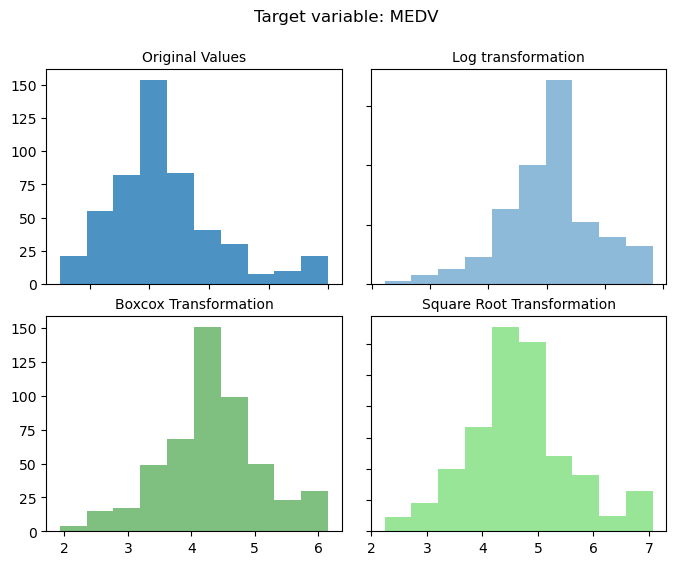

In [26]:
# MEDV Normalization: # Comparison Plot
fig =  plt.figure(figsize = (8, 6)) 
gs = fig.add_gridspec(2, 2, hspace = 0.15, wspace = 0.1)
(ax1, ax2), (ax3, ax4) = gs.subplots() 
plt.suptitle('Target variable: MEDV', fontsize = 12)
ax1.hist(boston_data.MEDV, alpha = 0.8)
ax1.set_title('Original Values', fontsize = 10)
ax2.hist(log_medv, alpha = 0.5)
ax2.set_title('Log transformation', fontsize = 10)
ax3.hist(boxcox_medv, color ='g', alpha = 0.5)
ax3.set_title('Boxcox Transformation', fontsize = 10)
ax4.hist(sqrt_medv, color = 'limegreen', alpha = 0.5)
ax4.set_title('Square Root Transformation', fontsize = 10)

for ax in fig.get_axes():
    ax.label_outer()

<h2 id ="Regression">4. Regression Analysis </h2> 

In [27]:
# Defining the Target (y) and Predictor variables (X):
target = 'MEDV'
X = boston_data.drop(target, axis=1)
y = boston_data[target]

# Create polynomial features
pf = PolynomialFeatures(degree=2, include_bias=False)
X_pf = pf.fit_transform(X)

In [28]:
lr = LinearRegression()

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=0.3, random_state=25980)

print("Number of test samples:", X_test.shape[0])
print("Number of training samples:", X_train.shape[0])

Number of test samples: 152
Number of training samples: 354


In [38]:
# Feature normalization
s = StandardScaler()
X_train_s = s.fit_transform(X_train)
X_test_s = s.transform(X_test)

In [39]:
# Target varibale normalization (Box-Cox)
# Box-Cox requires positive data. Check and potentially shift if needed.
if np.min(y_train) <= 0:
    # Add a small constant to make all values positive
    y_train_shifted = y_train + 1e-6
    bc_result2 = boxcox(y_train_shifted)
else:
    bc_result2 = boxcox(y_train)

y_train_bc = bc_result2[0]
lam2 = bc_result2[1]

In [33]:
# Shape of transformed target variable
y_train_bc.shape

(354,)

In [35]:
# Fit regression, Transform testing data and Predict on testing data
lr.fit(X_train_s, y_train_bc)
y_pred_bc = lr.predict(X_test_s)

In [40]:
# Inverse transformation and Model evaluation: R^2 
y_pred_test = inv_boxcox(y_pred_bc,lam2)

# If y_train was shifted, shift the predictions back
if np.min(y_train) <= 0:
    y_pred_test = y_pred_test - 1e-6

r2_score_test = r2_score(y_test, y_pred_test)
print(f'R^2 on testing data: {r2_score_test:.4f}')

mse = mean_squared_error(y_test, y_pred_test)
print(f'Mean squared error on testing data: {mse:.4f}')

rmse = np.sqrt(mse)
print(f'Root mean squared error on testing data: {rmse:.4f}')

R^2 on testing data: 0.7952
Mean squared error on testing data: 17.3815
Root mean squared error on testing data: 4.1691


___
Author: Olga Khon, PhD in Finance